# Fig 3: Plot model likelihood

In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time
import pickle

# Import x to one hot encoding
import utils 

# Logomaker
import logomaker

# jax import
import jax.random as random
import jax.numpy as jnp
from jax.numpy import DeviceArray

# numpyro imports
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, HMC, SVI
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

# arviz
#import arviz as az

# For visualization. Note that this notebook won't be making figure, so don't need to be picky. 
%matplotlib notebook

In [2]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0  # width of spines 
font.size:          7.0  # default font size
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of title
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Define inference parameters
@dataclass
class args:
    num_chains = 4
    num_samples = 500 
    num_warmup = 500 
    device = 'cpu'
    progress_bar = True
    target_accept_prob = 0.8
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

In [4]:
# Load combined MPSA and RNA-seq measurements
measurement_df = pd.read_csv('measurement_df.csv')

In [5]:
# Compute one-hot encoding of cropped sequences (i.e. without central '/GU')
cropped_seqs = measurement_df['ss'].str[:4]+measurement_df['ss'].str[7:]
ss_ohe = jnp.array(utils.x_to_ohe(cropped_seqs, alphabet_name='rna', ravel_seqs=False))

# Define the model
def model(model_type: str,
          ss_ohe: DeviceArray = None,
          measurement_df: pd.DataFrame = None) -> DeviceArray:

    ## GP map parameters for both drugs risdiplam and hyper motif
    theta_lc_scale = 5
    theta_0_scale = 5
    S_scale = 5
    L=8
    C=4
    theta_0_hyp = numpyro.sample('theta_0_hyp', 
                                 dist.Normal(loc=0, scale=theta_0_scale))
    theta_lc_hyp = numpyro.sample('theta_lc_hyp', 
                                  dist.Normal(loc=jnp.zeros((L,C)), scale=theta_lc_scale))
    theta_0_ris  = numpyro.sample('theta_0_ris', 
                                  dist.Normal(loc=0, scale=theta_0_scale))
    theta_lc_ris = numpyro.sample('theta_lc_ris', 
                                  dist.Normal(loc=jnp.zeros((L,C)), scale=theta_lc_scale))

    # Hill coefficients
    H_ris = 1.0 #numpyro.sample('H_ris', dist.Exponential(rate=1))
    H_bra = 1.0 #numpyro.sample('H_bra', dist.Exponential(rate=1))
    
    # Get number of sequences
    N = len(ss_ohe)

    # Context strength
    logS = numpyro.sample('logS', 
                          dist.Normal(loc=jnp.zeros((N,)), 
                          scale=S_scale))
    S = numpyro.deterministic('S', 
                              jnp.exp(logS))

    # phi values for ris and hyp motifs
    phi_ris = numpyro.deterministic(
                'phi_ris', 
                theta_0_ris + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_ris))
    phi_hyp = numpyro.deterministic(
                'phi_hyp', 
                theta_0_hyp + jnp.einsum('nlc,lc->n', ss_ohe, theta_lc_hyp))

    # Risdiplam effect
    E_ris = numpyro.deterministic('E_ris', 1+jnp.exp(phi_ris))
    E_ris_mpsa = numpyro.deterministic('E_ris_mpsa', 1 + jnp.exp(H_ris*phi_ris))

    # Branaplam effect (depends on model)
    if model_type=='A':
        E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp) + jnp.exp(phi_ris))
        E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*phi_hyp) + jnp.exp(H_bra*phi_ris))
    elif model_type=='B':
        E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp + phi_ris))
        E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*(phi_hyp + phi_ris)))
    elif model_type=='C':
        E_bra = numpyro.deterministic('E_bra', 1 + jnp.exp(phi_hyp))
        E_bra_mpsa = numpyro.deterministic('E_bra_mpsa', 1 + jnp.exp(H_bra*phi_hyp))
        
    # Drug strength for MPSA dataset
    R_ris = numpyro.deterministic('R_ris', S*E_ris_mpsa)        
    R_bra = numpyro.deterministic('R_bra', S*E_bra_mpsa)
    
    # Background noise for MPSA dataset
    B_ris = numpyro.sample('B_ris', dist.Exponential(1))
    B_bra = numpyro.sample('B_bra', dist.Exponential(1))
    B_dmso = numpyro.sample('B_dmso', dist.Exponential(1))

    # Log PSI for DMSO, risdiplam, and branaplam  for MPSA dataset
    log_psi_dmso = numpyro.deterministic('log_psi_dmso', jnp.log(100*S/(1+S) + B_dmso))
    log_psi_ris  = numpyro.deterministic('log_psi_ris', jnp.log(100*(R_ris)/(1+R_ris) + B_ris))
    log_psi_bra  = numpyro.deterministic('log_psi_bra', jnp.log(100*(R_bra)/(1+R_bra) + B_bra))
    
    # Log E for risdiplam and branaplam
    log_E_ris = numpyro.deterministic('log_E_ris', jnp.log(E_ris))
    log_E_bra = numpyro.deterministic('log_E_bra', jnp.log(E_bra))
    
    # Noise magnitude for MPSA meausurements of log PSI
    sigma_mpsa_dmso = numpyro.sample('sigma_mpsa_dmso', dist.Exponential(1))
    sigma_mpsa_ris = numpyro.sample('sigma_mpsa_ris', dist.Exponential(1))
    sigma_mpsa_bra = numpyro.sample('sigma_mpsa_bra', dist.Exponential(1))
    
    # Noise magnitude for RNA-seq measuremetns of log E
    sigma_rnaseq_ris = numpyro.sample('sigma_rnaseq_ris', dist.Exponential(1))
    sigma_rnaseq_bra = numpyro.sample('sigma_rnaseq_bra', dist.Exponential(1))        
        
    # Get indices to use for MPSA analysis
    mpsa_ix = measurement_df['use_for_mpsa_fit'].values
    mpsa_ixx = measurement_df[mpsa_ix].index.values

    # Get indices for RNA-seq analysis
    rnaseq_ix = measurement_df['use_for_rnaseq_fit'].values
    rnaseq_ixx = measurement_df[rnaseq_ix].index.values

    # Subset log PSI values for which we have observations
    log_psi_dmso_use = log_psi_dmso[mpsa_ixx]
    log_psi_ris_use = log_psi_ris[mpsa_ixx]
    log_psi_bra_use = log_psi_bra[mpsa_ixx]

    # Subset log E values for which we have observations
    log_E_ris_use = log_E_ris[rnaseq_ixx]
    log_E_bra_use = log_E_bra[rnaseq_ixx]

    # Get MPSA observations of log PSI
    obs_mpsa_dmso = jnp.array(measurement_df['log_psi_dmso'][mpsa_ix].values)
    obs_mpsa_ris = jnp.array(measurement_df['log_psi_risdiplam'][mpsa_ix].values)
    obs_mpsa_bra = jnp.array(measurement_df['log_psi_branaplam'][mpsa_ix].values)

    # Get RNA-seq observations of log E
    obs_rnaseq_ris = jnp.array(measurement_df['log_E_risdiplam'][rnaseq_ix].values)
    obs_rnaseq_bra = jnp.array(measurement_df['log_E_branaplam'][rnaseq_ix].values)

    # Match MPSA observations with predictions
    numpyro.sample('yhat_mpsa_dmso',
                   dist.Normal(loc=log_psi_dmso_use, scale=sigma_mpsa_dmso), 
                   obs=obs_mpsa_dmso)
    numpyro.sample('yhat_mpsa_ris', 
                   dist.Normal(loc=log_psi_ris_use, scale=sigma_mpsa_ris), 
                   obs=obs_mpsa_ris)
    numpyro.sample('yhat_mpsa_bra', 
                   dist.Normal(loc=log_psi_bra_use, scale=sigma_mpsa_bra), 
                   obs=obs_mpsa_bra)

    # Match RNA-seq observations with predictions
    numpyro.sample('yhat_rnaseq_ris', 
                   dist.Normal(loc=log_E_ris_use, scale=sigma_rnaseq_ris), 
                   obs=obs_rnaseq_ris)  
    numpyro.sample('yhat_rnaseq_bra', 
                   dist.Normal(loc=log_E_bra_use, scale=sigma_rnaseq_bra), 
                   obs=obs_rnaseq_bra)

In [6]:
import suftware as sw

# For some reason, sns.kdeplot() isn't working; use SUFTware
def deftplot(values, ax, **kwargs):
    values = np.array(values)
    dist = sw.DensityEstimator(values)
    x = dist.bin_edges
    y = dist.evaluate(x)
    ax.fill_between(x,y,alpha=.5, **kwargs)

<IPython.core.display.Javascript object>


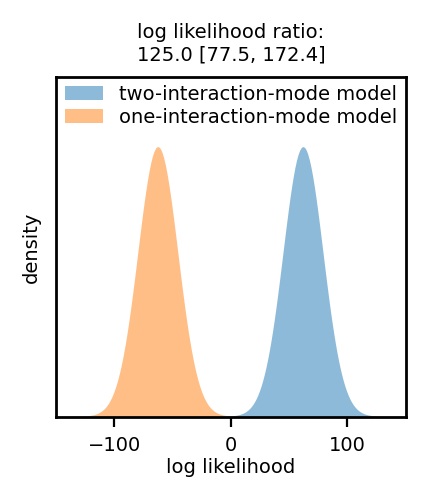

ll_ratio: 125.0 [77.5,172.4]


In [12]:
from jax import random, vmap
from numpyro import handlers

def ll_helper(rng_key, params, model, obs, *args, **kwargs):
    model = handlers.substitute(handlers.seed(model, rng_key), params)
    model_trace = handlers.trace(model).get_trace( *args, **kwargs)
    obs_node = model_trace[obs]
    return obs_node['fn'].log_prob(obs_node['value'])

def get_model_ll(model_type):
    
    # Load model
    file_name = f'joint_model_{model_type}.pkl'
    with open(file_name, 'rb') as f:
        params = pickle.load(f)
    
    # Get random key
    rng_key = random.PRNGKey(2)
    
    kwargs = dict(measurement_df = measurement_df,
                  model_type = model_type,
                  ss_ohe = ss_ohe)
    
    obs_list =['yhat_mpsa_dmso', 'yhat_mpsa_ris', 'yhat_mpsa_bra', 'yhat_rnaseq_ris', 'yhat_rnaseq_bra']
    n = list(params.values())[0].shape[0]
    log_obs = 0
    ll_df = pd.DataFrame()
    ll_dict = {}
    for obs in obs_list:
        log_lk_fn = vmap(lambda rng_key, params: ll_helper(rng_key, params, model, obs, **kwargs))
        log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
        ll_df[obs] = np.array(jnp.sum(log_lk_vals,axis=1))
    ll_df['total'] = ll_df.sum(axis=1)
    return ll_df

# Make figure
fig, ax = plt.subplots(1,1, figsize=[2.15,2.5])

# Get log likelihoods
lls_dict = {model_type:get_model_ll(model_type) for model_type in ['A','C']}
llA = lls_dict['A']['total'].values
llC = lls_dict['C']['total'].values

# Randomize arrays and compute ratios
np.random.seed(0)
np.random.shuffle(llA)
np.random.shuffle(llC)
ll_ratios = llA-llC

# Center all log likelihoods; this is fine
ll0 = .5*np.mean(llA) + .5*np.mean(llC)
llA = llA-ll0
llC = llC-ll0

# Compute median and 95% CI
ll_ratios = llA-llC
ll_ratio_med = np.median(ll_ratios)
ll_ratio_lo, ll_ratio_hi = np.quantile(a=ll_ratios, q=(.025, .975))
print(f'll_ratio: {ll_ratio_med:.1f} [{ll_ratio_lo:.1f},{ll_ratio_hi:.1f}]')

# Plot kde
bounding_box = [-150, 150]
deftplot(llA, label='two-interaction-mode model', ax = ax)
deftplot(llC, label='one-interaction-mode model', ax = ax)

# Style axes
ax.set_yticks([])
ax.set_ylabel('density', fontsize=7, labelpad=2)
ax.set_xlabel('log likelihood', fontsize=7)
ax.set_xlim(bounding_box)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), frameon=False)
ylim = list(ax.get_ylim())
ylim[0] = 0
ylim[1] = 1.2*ylim[1]
ax.set_ylim(ylim)
ax.set_title(f'log likelihood ratio:\n{ll_ratio_med:.1f} [{ll_ratio_lo:.1f}, {ll_ratio_hi:.1f}]')

fig.tight_layout()
fig.savefig('fig3B.pdf')

<IPython.core.display.Javascript object>


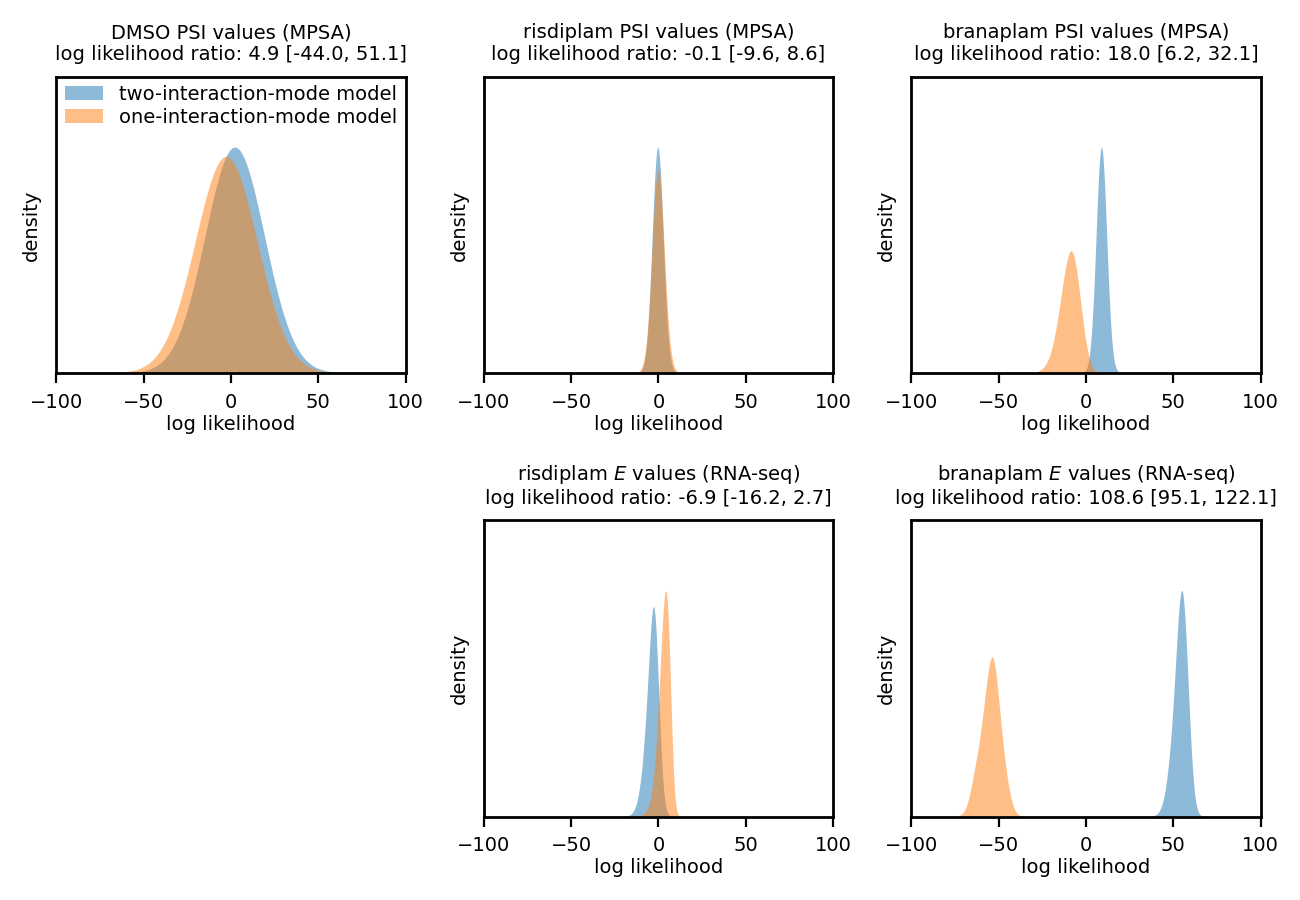

ll_ratio: 4.9 [-44.0, 51.1]
ll_ratio: -0.1 [-9.6, 8.6]
ll_ratio: 18.0 [6.2, 32.1]
ll_ratio: -6.9 [-16.2, 2.7]
ll_ratio: 108.6 [95.1, 122.1]


In [14]:
fig, axs = plt.subplots(2,3, figsize=[6.5,4.5])

model_types = list('CA')
lls_dict = {model_type:get_model_ll(model_type) for model_type in model_types}
label_dict = {'A':'two conf',
              'C':'one conf'}

def plot_kde(ax, obs, title, legend=False):

    # Get log likelihoods
    llA = lls_dict['A'][obs].values
    llC = lls_dict['C'][obs].values

    # Randomize arrays and compute ratios
    np.random.seed(0)
    np.random.shuffle(llA)
    np.random.shuffle(llC)
    ll_ratios = llA-llC

    # Center all log likelihoods; this is fine
    ll0 = .5*np.mean(llA) + .5*np.mean(llC)
    llA = llA-ll0
    llC = llC-ll0

    # Compute median and 95% CI
    ll_ratios = llA-llC
    ll_ratio_med = np.median(ll_ratios)
    ll_ratio_lo, ll_ratio_hi = np.quantile(a=ll_ratios, q=(.025, .975))
    print(f'll_ratio: {ll_ratio_med:.1f} [{ll_ratio_lo:.1f}, {ll_ratio_hi:.1f}]')
    
    deftplot(llA, label='two-interaction-mode model', ax = ax)
    deftplot(llC, label='one-interaction-mode model', ax = ax)
        
    # Style axes
    ax.set_yticks([])
    ax.set_ylabel('density', fontsize=7, labelpad=2)
    ax.set_xlabel('log likelihood', fontsize=7)
    ax.set_xlim([-100, 100])
    ylim = list(ax.get_ylim())
    ylim[0] = 0
    ylim[1] = 1.25*ylim[1]
    ax.set_ylim(ylim)
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), frameon=False)
        #ax.legend(loc='upper left')
    #ax.set_title(f'{title}\nlog evidence ratio: {d_log_evidence:.1f}')
    ax.set_title(f'{title}\nlog likelihood ratio: {ll_ratio_med:.1f} [{ll_ratio_lo:.1f}, {ll_ratio_hi:.1f}]')
    
plot_kde(ax=axs[0,0], 
         obs='yhat_mpsa_dmso', 
         title='DMSO PSI values (MPSA)',
         legend=True)

plot_kde(ax=axs[0,1], 
         obs='yhat_mpsa_ris', 
         title='risdiplam PSI values (MPSA)')

plot_kde(ax=axs[0,2], 
         obs='yhat_mpsa_bra', 
         title='branaplam PSI values (MPSA)')

axs[1,0].axis('off')

plot_kde(ax=axs[1,1], 
         obs='yhat_rnaseq_ris', 
         title='risdiplam $E$ values (RNA-seq)')

plot_kde(ax=axs[1,2], 
         obs='yhat_rnaseq_bra', 
         title='branaplam $E$ values (RNA-seq)')

fig.tight_layout()
fig.savefig('figS11.pdf')